In [1]:
import os
os.chdir('/mnt/ialabnas/homes/fidelrio/systematic-text-representations/')

import json
from pathlib import Path
import random
import pprint

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


import torch

from config import load_config
from data import build_datasets, build_loader, build_detailed_test_dataloaders
from data import CollatorForMaskedSelectedTokens, CollatorForMaskedRandomSelectedTokens, IdentityCollator
from data import ALL_POSSIBLE_COLORS
from model import MultimodalModel, MultimodalPretrainingModel
from utils import load_checkpoint
from lightning import Trainer, seed_everything
from tqdm.auto import tqdm, trange

from PIL import Image

from torch.utils.data import DataLoader, Subset
from torch.nn.functional import softmax

import numpy as np
from sklearn.decomposition import PCA

pp = pprint.PrettyPrinter(indent=2)

2024-09-04 10:46:55.790410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-8.0/lib64/
2024-09-04 10:46:55.790445: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def scene_tensor_to_txt(tensor):
    return ' '.join([processor.inv_vocabulary[t] for t in tensor.tolist()])

def print_scene_tensor(tensor):
    scene_text = scene_tensor_to_txt(tensor)
    print(scene_text.replace('[PAD]', '').replace('[SEP]','\n     '))
    
def print_parallel(tensor0, tensor1, tensor2, confidences, titles):
    ttl0, ttl1, ttl2 = titles
    print(f'{ttl0:6.6s} {ttl1:6.6s} {ttl2:6.6s}')
    for t0, t1, t2, conf in zip(
            tensor0.tolist(), tensor1.tolist(), tensor2.tolist(), confidences.tolist()):
        w0 = processor.inv_vocabulary[t0]
        w1 = processor.inv_vocabulary[t1]
        w2 = processor.inv_vocabulary[t2]
        
        if w0 == '[SEP]':
            print()
            continue
        if w0 == '[PAD]':
            break
        
        print_txt = f'{w0:6.6s} {w1:6.6s} {w2:6.6s} ({conf:.4f})'
        if w0 != w2:
            print_txt = bold(print_txt)
            

        print(print_txt)
        
def bold(text):
    return ("\033[1m" + text + "\033[0m")

In [82]:
class RandomPixelShuffle(object):
    def __call__(self, img):
        channels, height, width = img.size()
        indices = np.random.permutation(height * width)
        shuffled_img = img.view(channels, -1)[:, indices].view(channels, height, width)
        return shuffled_img

from torchvision import transforms
try:
    original_transform
except NameError:
    original_transform = processor.image_transform

# processor.image_transform = transforms.Compose([
#     original_transform,
#     RandomPixelShuffle()
# ])

In [73]:
device = torch.device('cuda')

n_colors = 8
epoch = None
exp_name = f'mmlm--n_colors={n_colors}c--mlm_probability=0.15'

checkpoint = load_checkpoint(exp_name, epoch=epoch)
print('Epoch:', checkpoint['epoch'])

Epoch: 999


In [74]:
!ls outputs/$exp_name

'epoch=149-step=22050.ckpt'  'epoch=649-step=95550.ckpt'
'epoch=199-step=29400.ckpt'  'epoch=699-step=102900.ckpt'
'epoch=19-step=2940.ckpt'    'epoch=69-step=10290.ckpt'
'epoch=249-step=36750.ckpt'  'epoch=749-step=110250.ckpt'
'epoch=299-step=44100.ckpt'  'epoch=799-step=117600.ckpt'
'epoch=29-step=4410.ckpt'    'epoch=79-step=11760.ckpt'
'epoch=349-step=51450.ckpt'  'epoch=849-step=124950.ckpt'
'epoch=399-step=58800.ckpt'  'epoch=899-step=132300.ckpt'
'epoch=39-step=5880.ckpt'    'epoch=89-step=13230.ckpt'
'epoch=449-step=66150.ckpt'  'epoch=949-step=139650.ckpt'
'epoch=499-step=73500.ckpt'  'epoch=999-step=147000.ckpt'
'epoch=49-step=7350.ckpt'    'epoch=99-step=14700.ckpt'
'epoch=549-step=80850.ckpt'  'epoch=9-step=1470.ckpt'
'epoch=599-step=88200.ckpt'   last.ckpt
'epoch=59-step=8820.ckpt'


In [75]:
config = load_config(exp_name)

config.vocabulary_path = config.vocabulary_path.replace('/workspace/' ,'/workspace1/')
config.base_path = config.base_path.replace('/workspace/' ,'/workspace1/')

# pp.pprint(vars(config))

train_dataset, test_dataset, systematic_dataset, common_systematic_dataset = build_datasets(config)
config.pad_idx = train_dataset.pad_idx
config.n_tokens = train_dataset.n_tokens

processor = test_dataset.processor
mask_token_idx = processor.vocabulary['[MASK]']
pad_token_idx = processor.vocabulary['[PAD]']

test_loaders = build_detailed_test_dataloaders(test_dataset, config) # type_of_tokens_to_test
systematic_loaders = build_detailed_test_dataloaders(systematic_dataset, config) # type_of_tokens_to_test

model = MultimodalModel(config).to(device)
training_model = MultimodalPretrainingModel(model, config).to(device)
training_model.load_state_dict(checkpoint['state_dict'])

Loading mmlm--n_colors=8c--mlm_probability=0.15 last checkpoint config from outputs/mmlm--n_colors=8c--mlm_probability=0.15/last.ckpt
Add new arg: permute_pixels = False
Add new arg: aug_zero_color = False


In [89]:
trainer = Trainer(max_epochs=config.max_epochs,
                  accelerator="gpu",
                  devices=torch.cuda.device_count()
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [90]:
vocab = processor.vocabulary

relation_tokens = sorted(
    [vocab[w] for w in ['left', 'right', 'behind', 'front'] if w in vocab])
colors_tokens = sorted(
    [vocab[w] for w in ALL_POSSIBLE_COLORS if w in vocab])
#     [vocab[w] for w in ['blue', 'brown', 'cyan', 'green', 'red', 'purple', 'yellow', 'gray']])
shapes_tokens = sorted(
    [vocab[w] for w in ['cylinder', 'sphere', 'cube'] if w in vocab])
materials_tokens = sorted(
    [vocab[w] for w in ['metal', 'rubber'] if w in vocab])
sizes_tokens = sorted(
    [vocab[w] for w in ['small', 'large'] if w in vocab])

random_baseline = {
    'relation':  1 / len(relation_tokens),
    'color':  1 / len(color_tokens),
    'shapes':  1 / len(shapes_tokens),
    'materials':  1 / len(materials_tokens),
    'size':  1 / len(size_tokens),
    'identity':  1 / len(processor.vocabulary),
}

In [91]:
batch_size = 256
test_indices = random.sample(range(len(test_dataset)), k=batch_size)
pc_subset_test = Subset(test_dataset, test_indices)
pc_subset_systematic = Subset(systematic_dataset, test_indices)

colors_collator = CollatorForMaskedSelectedTokens(config, processor, tokens=colors_tokens)
shapes_collator = CollatorForMaskedSelectedTokens(config, processor, tokens=shapes_tokens)
materials_collator = CollatorForMaskedSelectedTokens(config, processor, tokens=materials_tokens)
sizes_collator = CollatorForMaskedSelectedTokens(config, processor, tokens=sizes_tokens)
dlkwargs = {
    'batch_size': batch_size,
    'num_workers': int(os.environ.get("SLURM_CPUS_PER_TASK", 4)),
    'pin_memory': torch.cuda.is_available(),
}

for task, collator in [('colors', colors_collator),
                       ('shapes', shapes_collator),
                       ('materials', materials_collator),
                       ('sizes', sizes_collator)]:
    
    test_loaders[task] = DataLoader(
        pc_subset_test, shuffle=False, collate_fn=collator, **dlkwargs)
    systematic_loaders[task] = DataLoader(
        pc_subset_systematic, shuffle=False, collate_fn=collator, **dlkwargs)
    

In [92]:
feature_maps = []  # This will be a list of Tensors, each representing a feature map

def hook_feat_map(mod, inp, out):
    feature_maps.clear()
    feature_maps.append(out)

model.transformer.register_forward_hook(hook_feat_map)

In [95]:
def get_props(scenes):
    sizes = scenes[:,1:][:,0::5]
    colors = scenes[:,1:][:,1::5]
    materials = scenes[:,1:][:,2::5]
    shapes = scenes[:,1:][:,3::5]

    sizes = sizes[sizes != pad_token_idx].cpu()
    colors = colors[colors != pad_token_idx].cpu()
    materials = materials[materials != pad_token_idx].cpu()
    shapes = shapes[shapes != pad_token_idx].cpu()
    return sizes, colors, materials, shapes

In [94]:
tasks = ['colors', 'shapes', 'materials', 'sizes']

feats_by_set = {}
gt_by_set = {}
props_by_set = {}
for test_name, loaders in [('test', test_loaders), ('systematic', systematic_loaders)]:
    feats_by_task = {}
    gt_by_task = {}
    props_by_task = {}
    for task in tasks:
        images, scenes, labels = next(iter(loaders[task]))
        images, scenes, labels = images.to(device), scenes.to(device), labels.to(device)
        cimages, cscenes, clabels = images, scenes, labels
        with torch.no_grad():
            output_logits = model(images, scenes)

            features = feature_maps[0]
            confidences = softmax(output_logits, dim=-1).max(dim=-1).values
            predictions = output_logits.argmax(dim=-1)

            scene_features = features.transpose(1,0)[:,-config.max_scene_size:]
            mask_idxs = (scenes == mask_token_idx)
            gt_by_task[task] = labels[:,-config.max_scene_size:][mask_idxs].cpu()
            feats_by_task[task] = scene_features[mask_idxs].cpu()
            props_by_task[task] = get_props(scenes)
            sizes, colors, materials, shapes = props_by_task[task]
   
    feats_by_set[test_name] = feats_by_task
    gt_by_set[test_name] = gt_by_task
    props_by_set[test_name] = props_by_task

In [97]:
clf_idxs = torch.unique(torch.cat([gt_by_set['test'][t] for t in tasks]))
clf_idxs_by_task = {t: torch.unique(gt_by_set['test'][t]) for t in tasks}
all_clf_vectors = model.classifier.weight.data.cpu()
clf_vectors = model.classifier.weight.data.cpu()[clf_idxs]
clf_vectors_by_task = {t: all_clf_vectors[tidxs] for t, tidxs in clf_idxs_by_task.items()}
all_word_vectors = model.word_embedding.weight.data.cpu()
word_vectors = model.word_embedding.weight.data.cpu()[clf_idxs]
word_vectors_by_task = {t: all_clf_vectors[tidxs] for t, tidxs in clf_idxs_by_task.items()}

In [98]:
def scatter_pca(X,
                y, 
                title='', 
                special_X=None, 
                special_y=None, 
                don_t_label_these=[], 
                labels_to_use=[], 
                special_labels_to_use=[], 
                ax=None):
    
    is_3d = X.shape[-1] == 3
    
    if ax is None:
        fig = plt.figure(figsize=(9*1.75,5*1.75))
        if is_3d:
            ax = fig.add_subplot(projection='3d')
        else:
            ax = fig.add_subplot()

    label_namer = processor.inv_vocabulary
    if labels_to_use:
        label_namer = labels_to_use
    for label_idx in sorted(set(y)):
        idxs = y == label_idx 
        label = label_namer[label_idx]

        plot_args = [X[:,0][idxs], X[:,1][idxs]]
        if is_3d:
            plot_args = plot_args + [X[:,2][idxs]]

        plot_kwargs = {}
        if not don_t_label_these or label not in don_t_label_these:
            plot_kwargs['label'] = label

        scatter_shapes = ax.scatter(*plot_args, **plot_kwargs)
  
    special_label_namer = processor.inv_vocabulary
    if labels_to_use:
        special_label_namer = labels_to_use
    if special_labels_to_use:
        special_label_namer = special_labels_to_use
    if special_X is not None:
        for label_idx in sorted(set(special_y)): 
            label = special_label_namer[label_idx]

            plot_kwargs = {}
            if not don_t_label_these or label not in don_t_label_these:
                plot_kwargs['label'] = label

            special_idxs = special_y == label_idx 
            special_plot_args = [special_X[:,0][special_idxs], special_X[:,1][special_idxs]]
            if is_3d:
                special_plot_args = special_plot_args + [special_X[:,2][special_idxs]]

#             color = scatter_shapes.get_facecolors()[0]
#             plot_kwargs['color'] = color
            plot_kwargs['marker'] = '*'
            if not is_3d:
                plot_kwargs['s'] = 200
        
            ax.scatter(*special_plot_args, **plot_kwargs)


    if title:
        ax.set_title(title)
    ax.legend(framealpha=1, loc='upper left')

    # Show plot
    # plt.savefig('exports/base-attributes.pdf', format='pdf', dpi=300, bbox_inches='tight')
    if not ax:
        plt.show()

In [99]:
don_t_label_these = [] if n_colors <= 27 else ALL_POSSIBLE_COLORS 

### All Tasks

In [100]:
%matplotlib inline

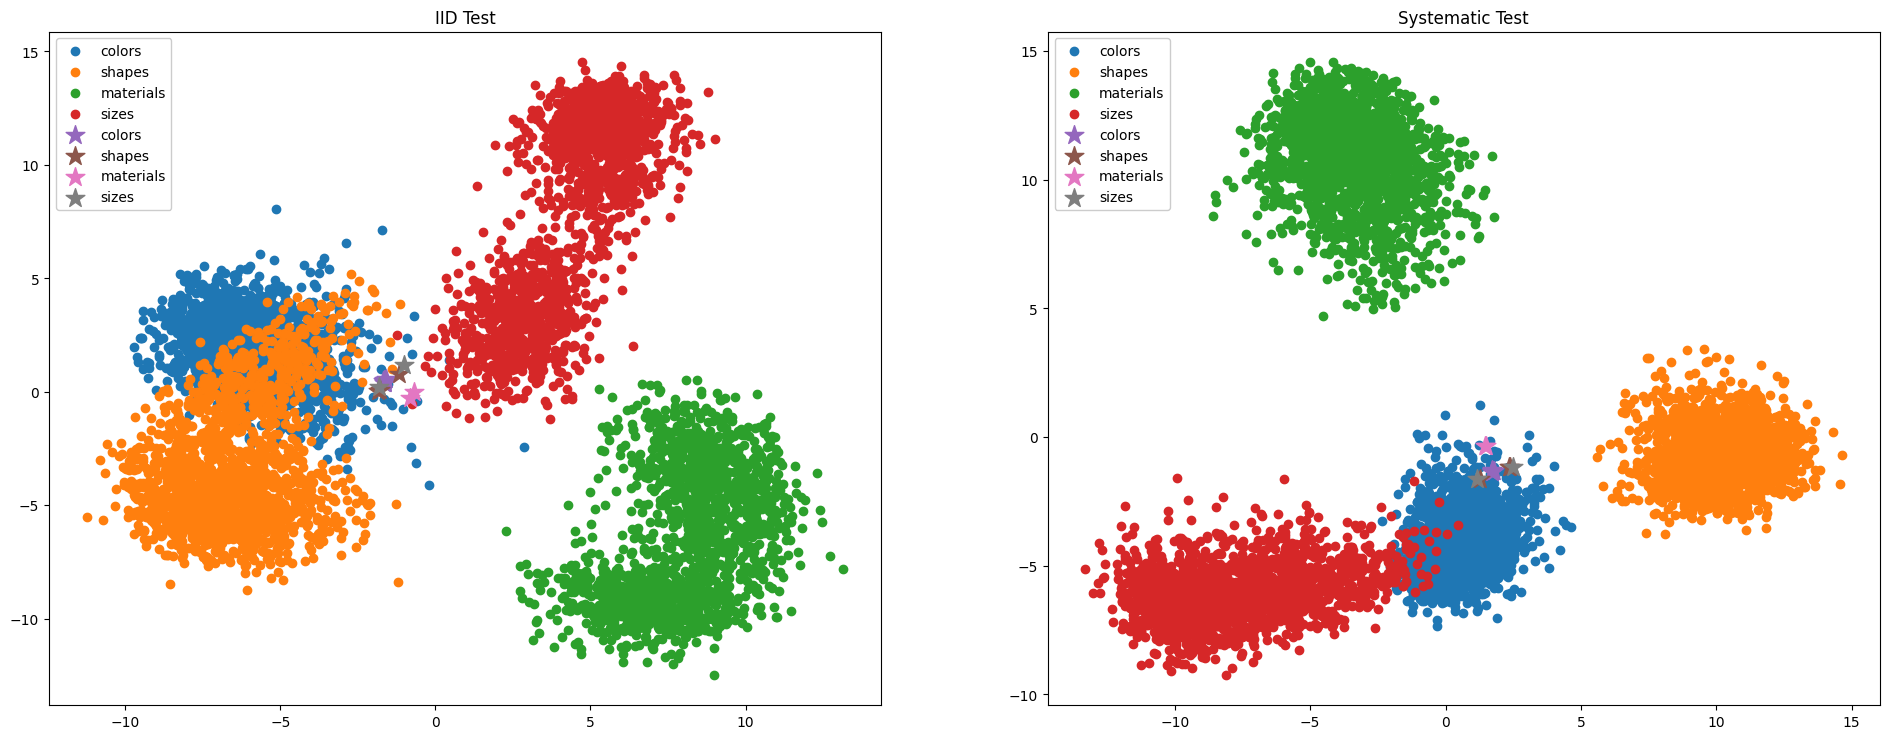

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

labels_to_use = tasks

X = torch.cat([feats_by_set['test'][t] for t in tasks]).numpy()
all_gts = [torch.full_like(gt_by_set['test'][t], tidx) for tidx, t in enumerate(tasks)]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

special_X = torch.cat([clf_vectors_by_task[t] for t in tasks]).numpy()
special_gts = [torch.full_like(clf_idxs_by_task[t], tidx) for tidx, t in enumerate(tasks)]
special_gts = torch.cat(special_gts).numpy()
X_2d_clf = pca.transform(clf_vectors)
# X_2d_clf = pca.transform(word_vectors)

scatter_pca(X_2d,
            all_gts,
            labels_to_use=labels_to_use,
            special_X=X_2d_clf,
            special_y=special_gts,
            title='IID Test',
            don_t_label_these=don_t_label_these,
            ax=axs[0])


X = torch.cat([feats_by_set['systematic'][t] for t in tasks]).numpy()
all_gts = [torch.full_like(gt_by_set['systematic'][t], tidx) for tidx, t in enumerate(tasks)]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

X_2d_clf = pca.transform(clf_vectors)
# X_2d_clf = pca.transform(word_vectors)

scatter_pca(X_2d,
            all_gts,
            labels_to_use=labels_to_use,
            special_X=X_2d_clf,
            special_y=special_gts,
            title='Systematic Test',
            don_t_label_these=don_t_label_these,
            ax=axs[1])

plt.show()

### Concept Embedding

In [102]:
# %matplotlib notebook
%matplotlib inline

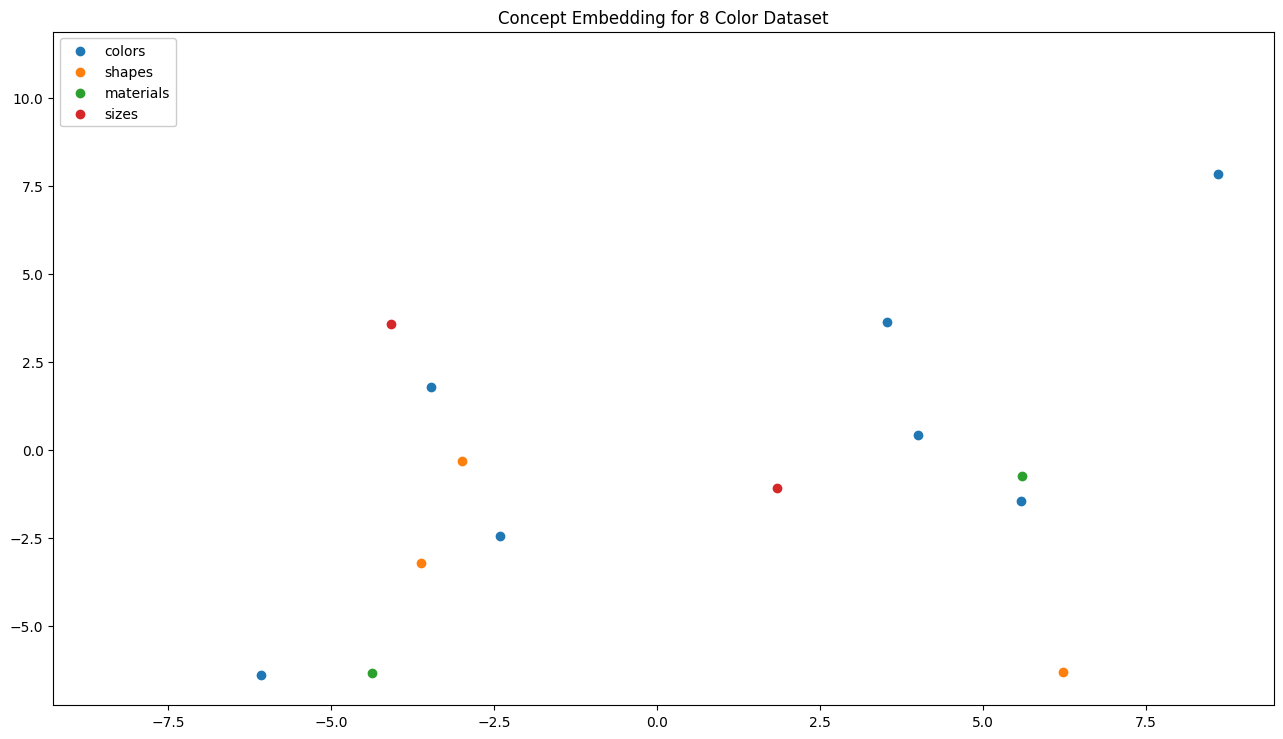

In [103]:
# fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

labels_to_use = tasks

# X = torch.cat([feats_by_set['test'][t] for t in tasks]).numpy()
# all_gts = [torch.full_like(gt_by_set['test'][t], tidx) for tidx, t in enumerate(tasks)]
# all_gts = torch.cat(all_gts).numpy()


X = torch.cat([clf_vectors_by_task[t] for t in tasks] + 
              [word_vectors_by_task[t] for t in tasks]).numpy()

clf_gts = [torch.full_like(clf_idxs_by_task[t], tidx) for tidx, t in enumerate(tasks)]
word_gts = [torch.full_like(clf_idxs_by_task[t], tidx) for tidx, t in enumerate(tasks)]



pca = PCA(n_components=2)
# _ = pca.fit_transform(X)
X_2d_word = pca.fit_transform(word_vectors)
word_gts = torch.cat(word_gts).numpy()

X_2d_clf = pca.transform(clf_vectors)
clf_gts = torch.cat(clf_gts).numpy()

scatter_pca(X_2d_word,
            word_gts,
            labels_to_use=labels_to_use,
            title=f'Concept Embedding for {n_colors} Color Dataset',
            don_t_label_these=don_t_label_these,
#             special_X=X_2d_clf,
#             special_y=special_gts,
#             ax=axs[0]
           )

# scatter_pca(X_2d_clf,
#             clf_gts,
#             labels_to_use=labels_to_use,
#             title='Classifier',
#             don_t_label_these=don_t_label_these,
# #             special_X=X_2d_clf,
# #             special_y=special_gts,
#             ax=axs[1]
#            )

# plt.show()

In [34]:
# %matplotlib notebook

In [35]:
# fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

# labels_to_use = tasks

# X = torch.cat([feats_by_set['test'][t] for t in tasks]).numpy()
# all_gts = [torch.full_like(gt_by_set['test'][t], tidx) for tidx, t in enumerate(tasks)]
# all_gts = torch.cat(all_gts).numpy()

# pca = PCA(n_components=3)
# X_3d = pca.fit_transform(X)

# special_X = torch.cat([clf_vectors_by_task[t] for t in tasks]).numpy()
# special_gts = [torch.full_like(clf_idxs_by_task[t], tidx) for tidx, t in enumerate(tasks)]
# special_gts = torch.cat(special_gts).numpy()
# X_3d_clf = pca.transform(clf_vectors)

# scatter_pca(X_3d,
#             all_gts,
#             labels_to_use=labels_to_use,
#             special_X=X_3d_clf,
#             special_y=special_gts,
#             title='IID Test',
#             don_t_label_these=don_t_label_these,
#             ax=axs[0])


# X = torch.cat([feats_by_set['systematic'][t] for t in tasks]).numpy()
# all_gts = [torch.full_like(gt_by_set['systematic'][t], tidx) for tidx, t in enumerate(tasks)]
# all_gts = torch.cat(all_gts).numpy()

# pca = PCA(n_components=2)
# X_3d = pca.fit_transform(X)

# X_3d_clf = pca.transform(clf_vectors)

# scatter_pca(X_3d,
#             all_gts,
#             labels_to_use=labels_to_use,
#             special_X=X_3d_clf,
#             special_y=special_gts,
#             title='Systematic Test',
#             don_t_label_these=don_t_label_these,
#             ax=axs[1])

# plt.show()

In [36]:
%matplotlib inline

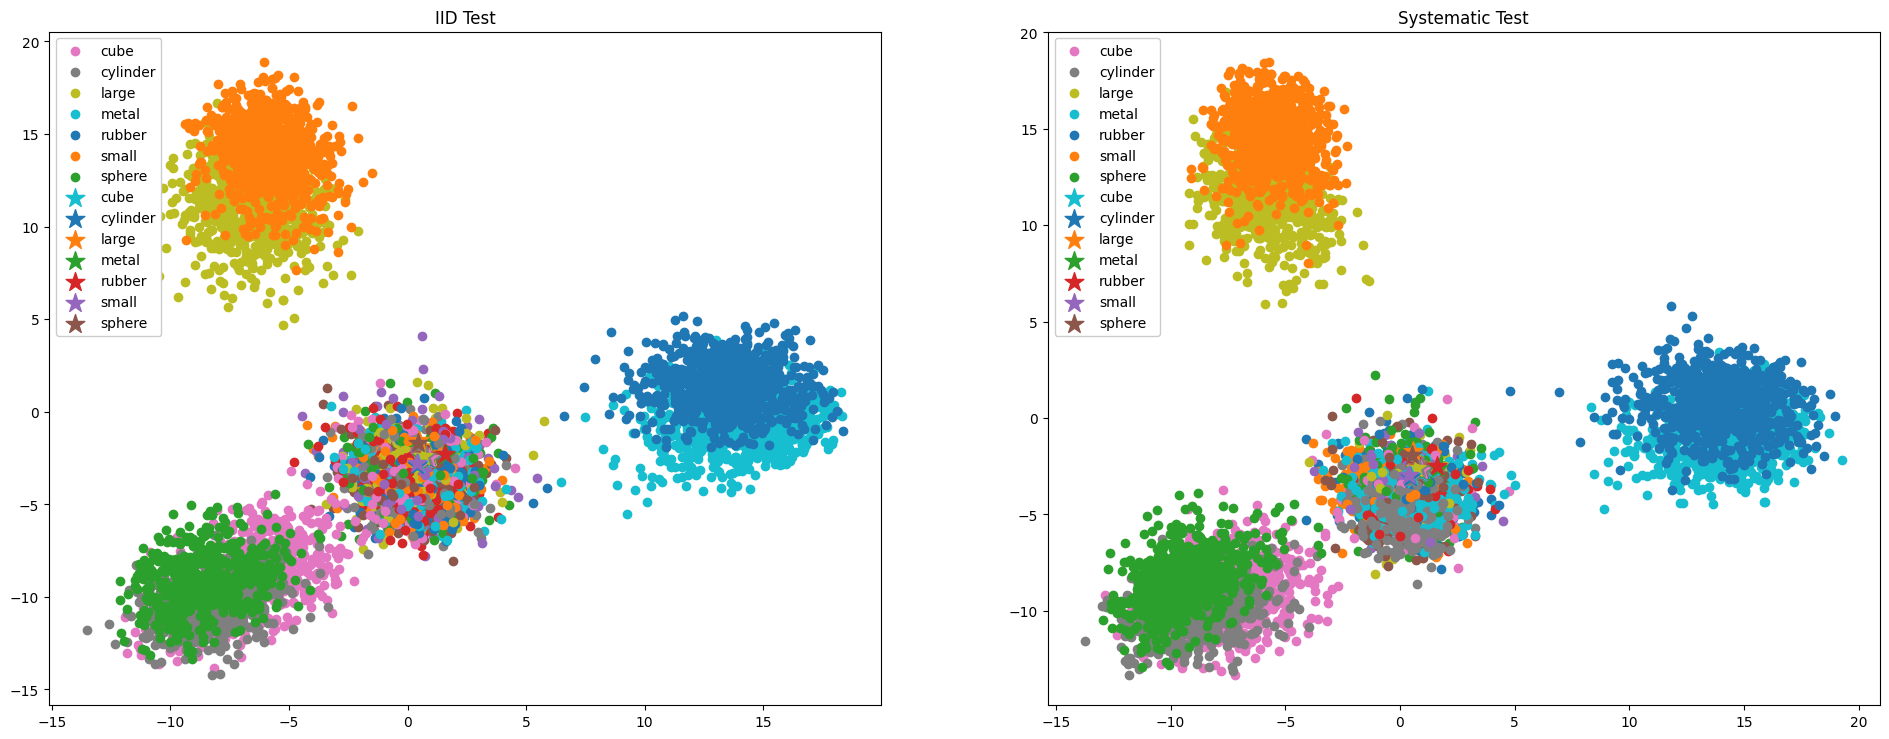

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

labels_to_use = tasks

X = torch.cat([feats_by_set['test'][t] for t in tasks]).numpy()
all_gts = torch.cat([gt_by_set['test'][t] for t in tasks]).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)


special_X = torch.cat([clf_vectors_by_task[t] for t in tasks]).numpy()
special_gts = torch.cat([clf_idxs_by_task[t] for t in tasks]).numpy()
X_2d_clf = pca.transform(clf_vectors)

scatter_pca(X_2d,
            all_gts,
#             labels_to_use=labels_to_use,
            special_X=X_2d_clf,
            special_y=special_gts,
            title='IID Test',
            don_t_label_these=don_t_label_these,
            ax=axs[0])


X = torch.cat([feats_by_set['systematic'][t] for t in tasks]).numpy()
all_gts = torch.cat([gt_by_set['systematic'][t] for t in tasks]).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

X_2d_clf = pca.transform(clf_vectors)

scatter_pca(X_2d,
            all_gts,
#             labels_to_use=labels_to_use,
            special_X=X_2d_clf,
            special_y=special_gts,
            title='Systematic Test',
            don_t_label_these=don_t_label_these,
            ax=axs[1])

plt.show()

### Color + Shape Tasks

In [38]:
%matplotlib inline

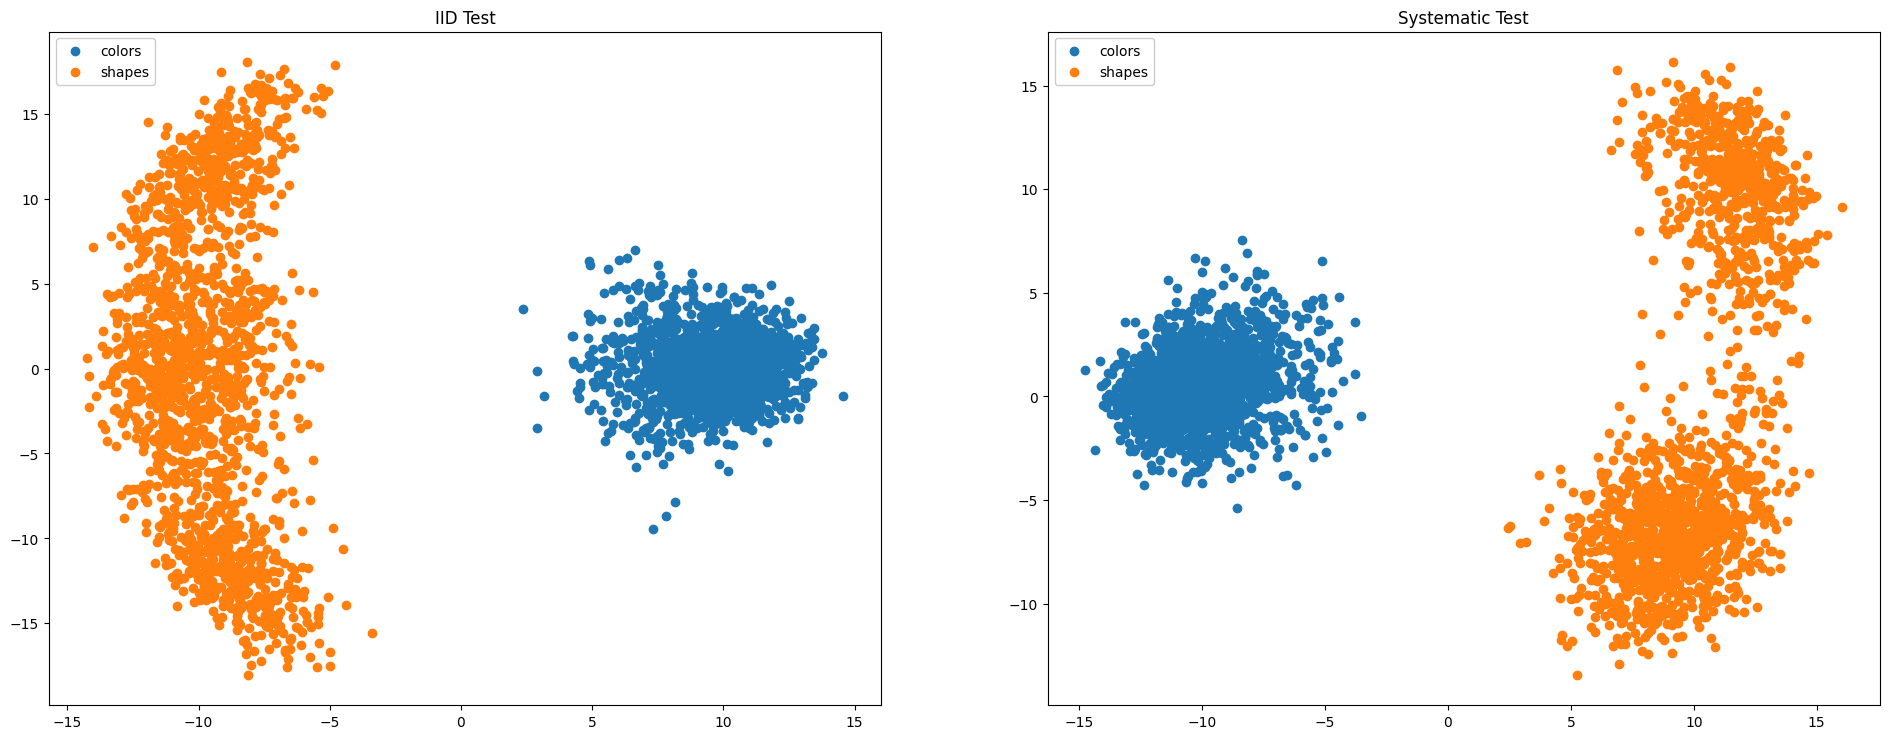

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

labels_to_use = ['colors', 'shapes']

X = torch.cat([feats_by_set['test'][t] for t in ['colors', 'shapes']]).numpy()
all_gts = [torch.full_like(gt_by_set['test'][t], tidx) for tidx, t in enumerate(['colors', 'shapes'])]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(
    X_2d, 
    all_gts, 
    labels_to_use=labels_to_use, 
    title='IID Test',
    don_t_label_these=don_t_label_these,
    ax=axs[0])


X = torch.cat([feats_by_set['systematic'][t] for t in ['colors', 'shapes']]).numpy()
all_gts = [torch.full_like(gt_by_set['systematic'][t], tidx) for tidx, t in enumerate(['colors', 'shapes'])]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(
    X_2d,
    all_gts,
    labels_to_use=labels_to_use,
    title='Systematic Test',
    don_t_label_these=don_t_label_these,
    ax=axs[1])

plt.show()

In [40]:
%matplotlib inline

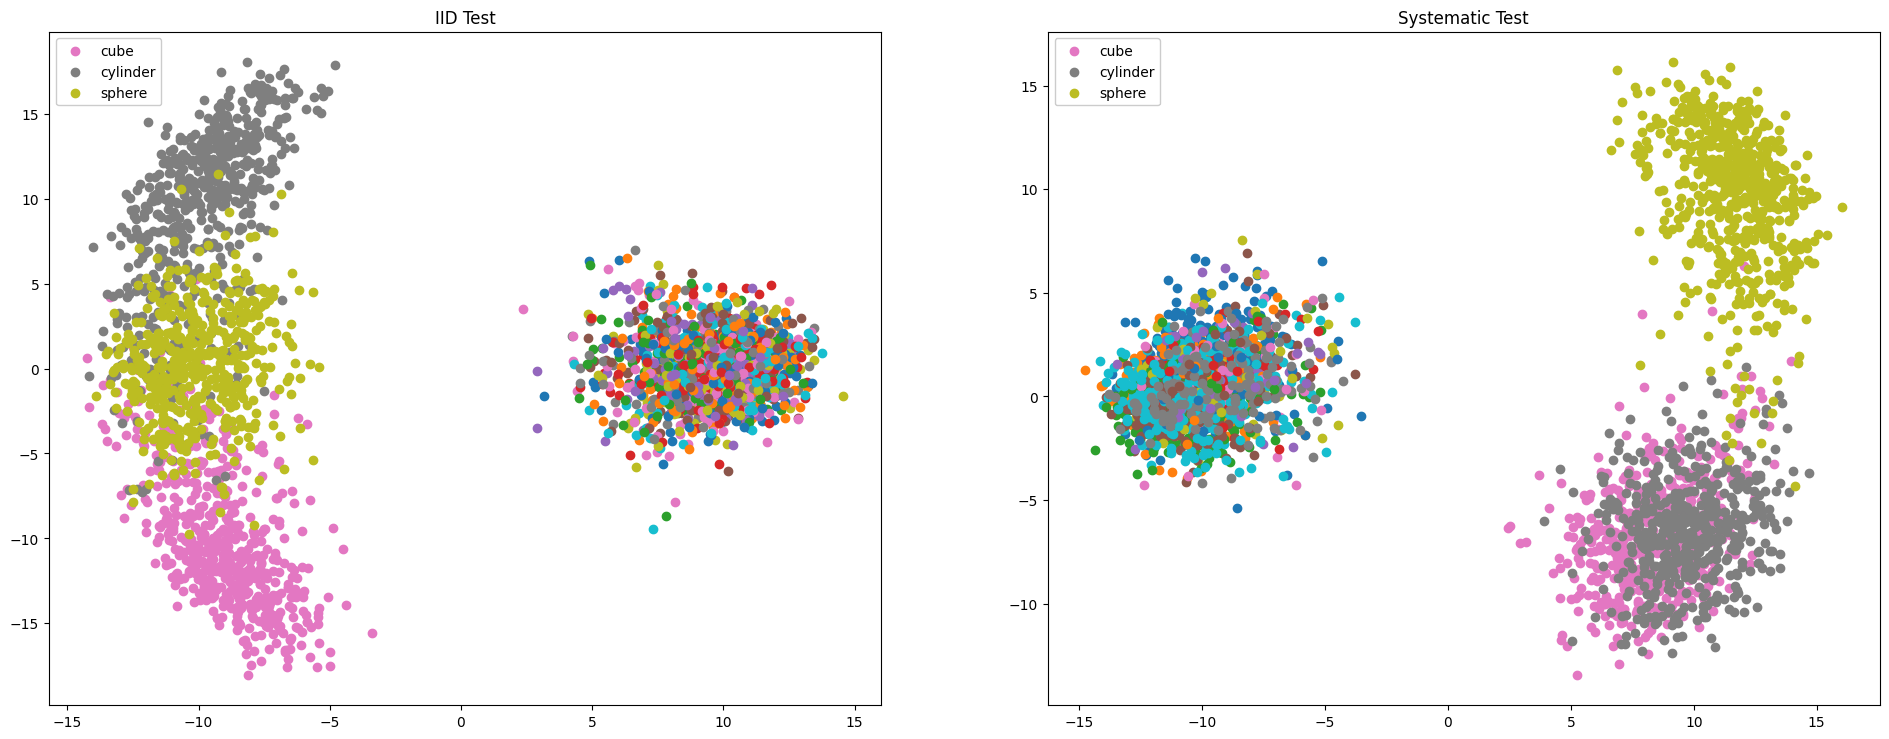

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

X = torch.cat([feats_by_set['test'][t] for t in ['colors', 'shapes']]).numpy()
all_gts = torch.cat([gt_by_set['test'][t] for t in ['colors', 'shapes']]).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, 
            all_gts, 
            don_t_label_these=don_t_label_these,
            title='IID Test', 
            ax=axs[0])


X = torch.cat([feats_by_set['systematic'][t] for t in ['colors', 'shapes']]).numpy()
all_gts = torch.cat([gt_by_set['systematic'][t] for t in ['colors', 'shapes']]).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, 
            all_gts, 
            don_t_label_these=don_t_label_these, 
            title='Systematic Test', 
            ax=axs[1])

plt.show()

### Color Task

In [42]:
%matplotlib inline

In [43]:
special_X = torch.cat([clf_vectors_by_task[t] for t in ['colors']]).numpy()
special_gts = torch.cat([clf_idxs_by_task[t] for t in ['colors']]).numpy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


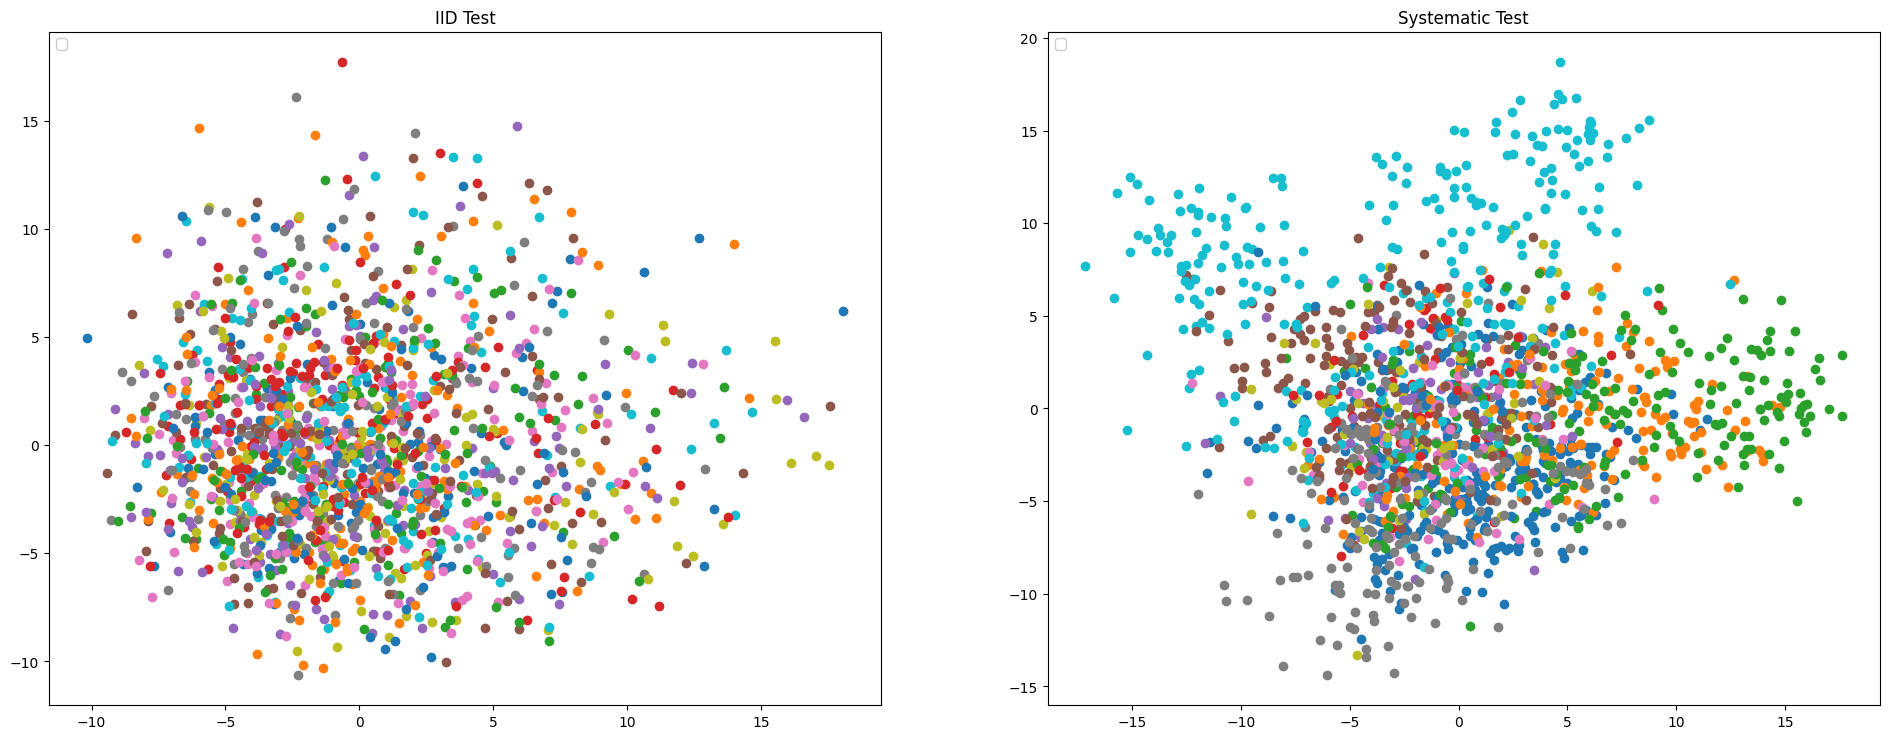

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

X = feats_by_set['test']['colors'].numpy()
all_gts = gt_by_set['test']['colors'].numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, don_t_label_these=don_t_label_these, title='IID Test', ax=axs[0])


X = feats_by_set['systematic']['colors'].numpy()
all_gts = gt_by_set['systematic']['colors'].numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, don_t_label_these=don_t_label_these, title='Systematic Test', ax=axs[1])

plt.show()

In [45]:
%matplotlib inline

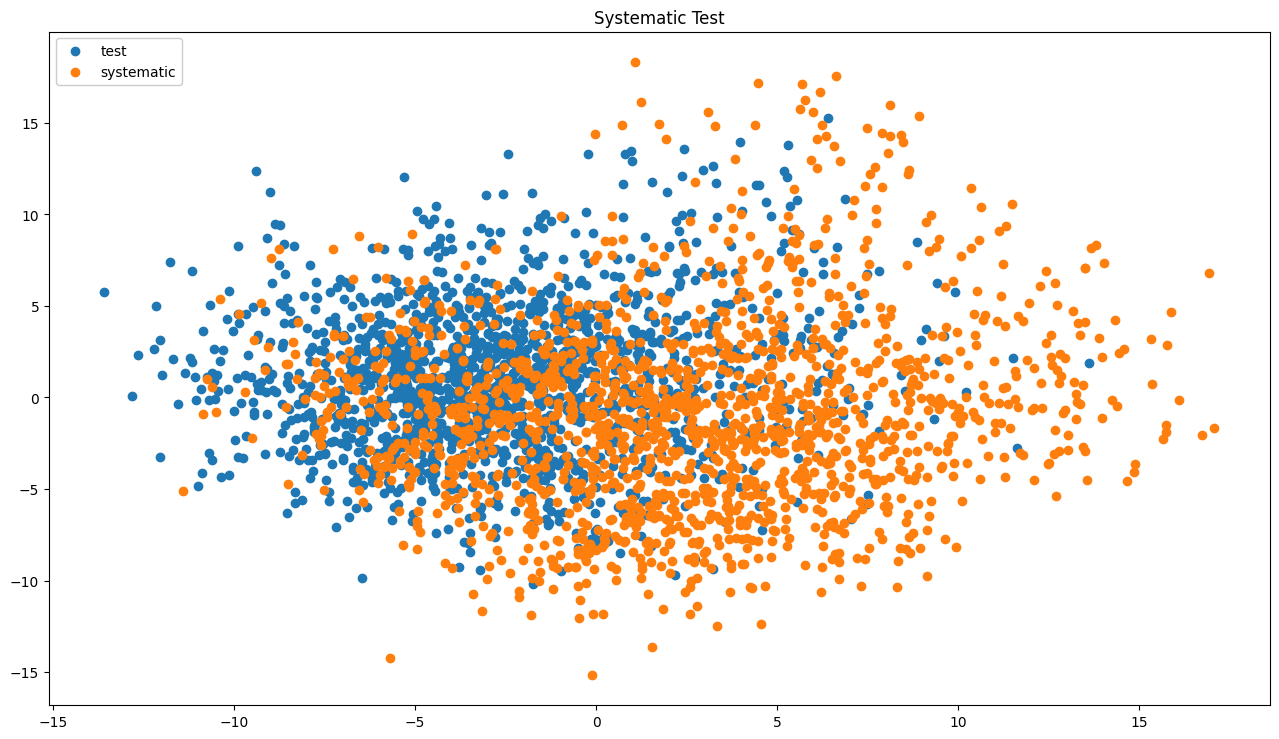

In [46]:
X = torch.cat([feats_by_set[set_]['colors'] for set_ in ['test', 'systematic']]).numpy()
all_gts = [torch.full_like(gt_by_set[set_]['colors'], tidx) for tidx, set_ in enumerate(['test', 'systematic'])]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, labels_to_use=['test', 'systematic'], don_t_label_these=[], title='Systematic Test')

In [47]:
# %matplotlib notebook

In [48]:
# X = torch.cat([feats_by_set[set_]['colors'] for set_ in ['test', 'systematic']]).numpy()
# all_gts = [torch.full_like(gt_by_set[set_]['colors'], tidx) for tidx, set_ in enumerate(['test', 'systematic'])]
# all_gts = torch.cat(all_gts).numpy()

# pca = PCA(n_components=3)
# X_3d = pca.fit_transform(X)

# scatter_pca(X_3d, all_gts, labels_to_use=['test', 'systematic'], don_t_label_these=[], title='Systematic Test')

In [49]:
# X = torch.cat([feats_by_set[set_]['colors'] for set_ in ['test', 'systematic']]).numpy()
# all_gts = [gt_by_set[set_]['colors'] for set_ in ['test', 'systematic']]
# all_gts = torch.cat(all_gts).numpy()

# pca = PCA(n_components=3)
# X_3d = pca.fit_transform(X)

# scatter_pca(X_3d,
#             all_gts,
# #             labels_to_use=['test', 'systematic'],
#             don_t_label_these=don_t_label_these,
#             title='Systematic Test')

### Shape Task

In [50]:
%matplotlib inline

In [51]:
special_X = torch.cat([clf_vectors_by_task[t] for t in ['shapes']]).numpy()
special_gts = torch.cat([clf_idxs_by_task[t] for t in ['shapes']]).numpy()


# special_X = torch.cat([clf_vectors_by_task[t] for t in tasks]).numpy()
# special_gts = torch.cat([clf_idxs_by_task[t] for t in tasks]).numpy()
# X_2d_clf = pca.transform(special_X)

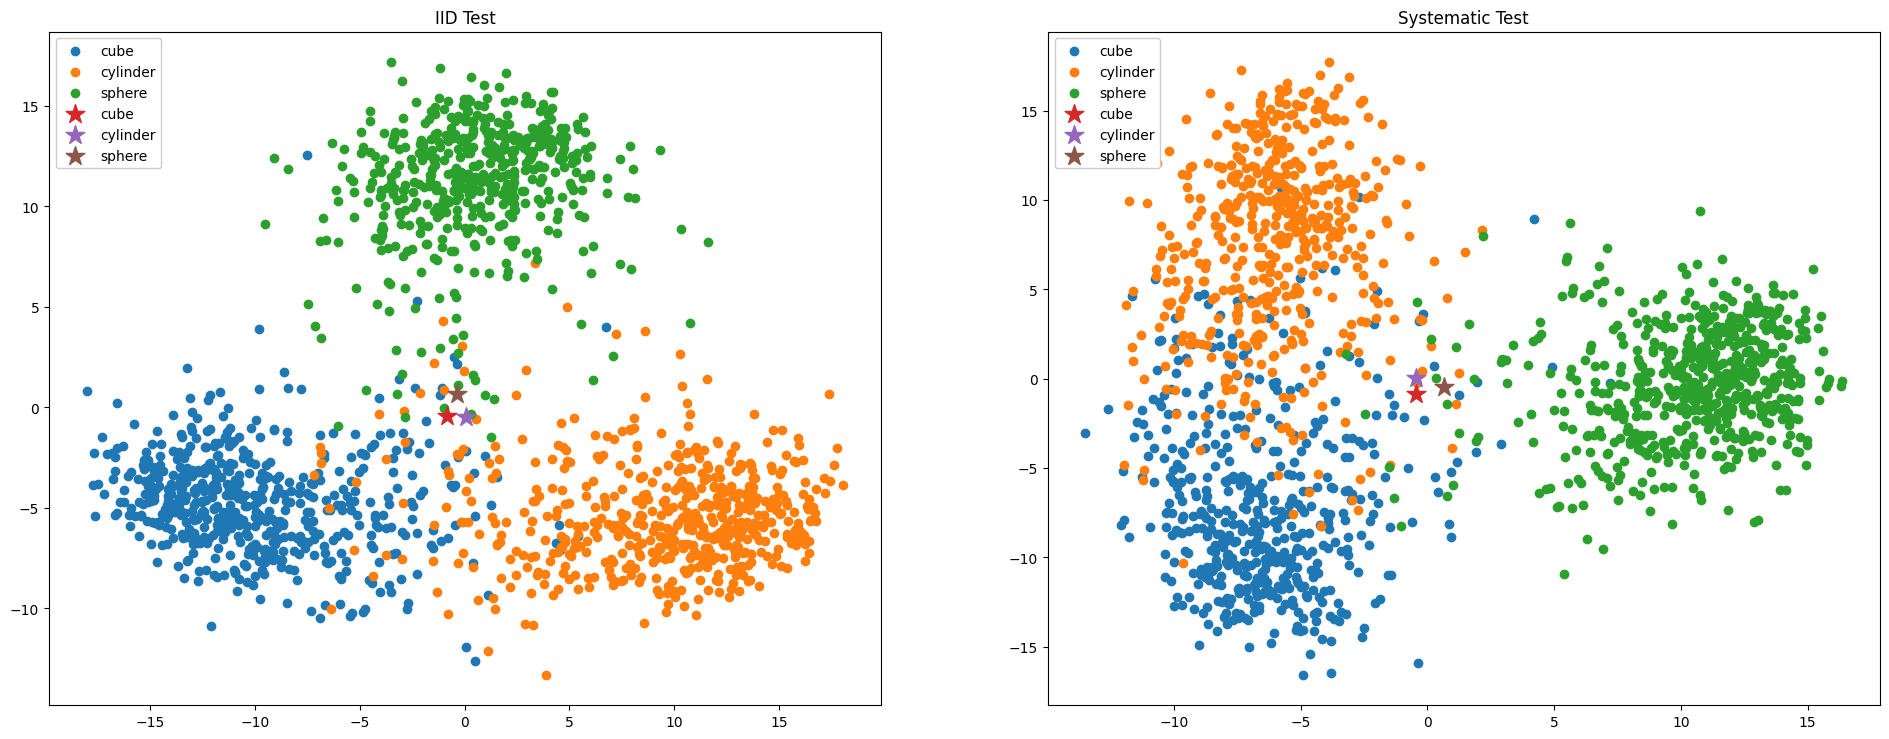

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

X = feats_by_set['test']['shapes'].numpy()
all_gts = gt_by_set['test']['shapes'].numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)


scatter_pca(
    X_2d, 
    all_gts, 
    special_X=pca.transform(special_X),
    special_y=special_gts,
    don_t_label_these=[], 
    title='IID Test', 
    ax=axs[0])


X = feats_by_set['systematic']['shapes'].numpy()
all_gts = gt_by_set['systematic']['shapes'].numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(
    X_2d, 
    all_gts, 
    special_X=pca.transform(special_X),
    special_y=special_gts,
    don_t_label_these=[], 
    title='Systematic Test', 
    ax=axs[1])

# plt.savefig(
#     'exports/acc-color-smaller-models.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
%matplotlib inline

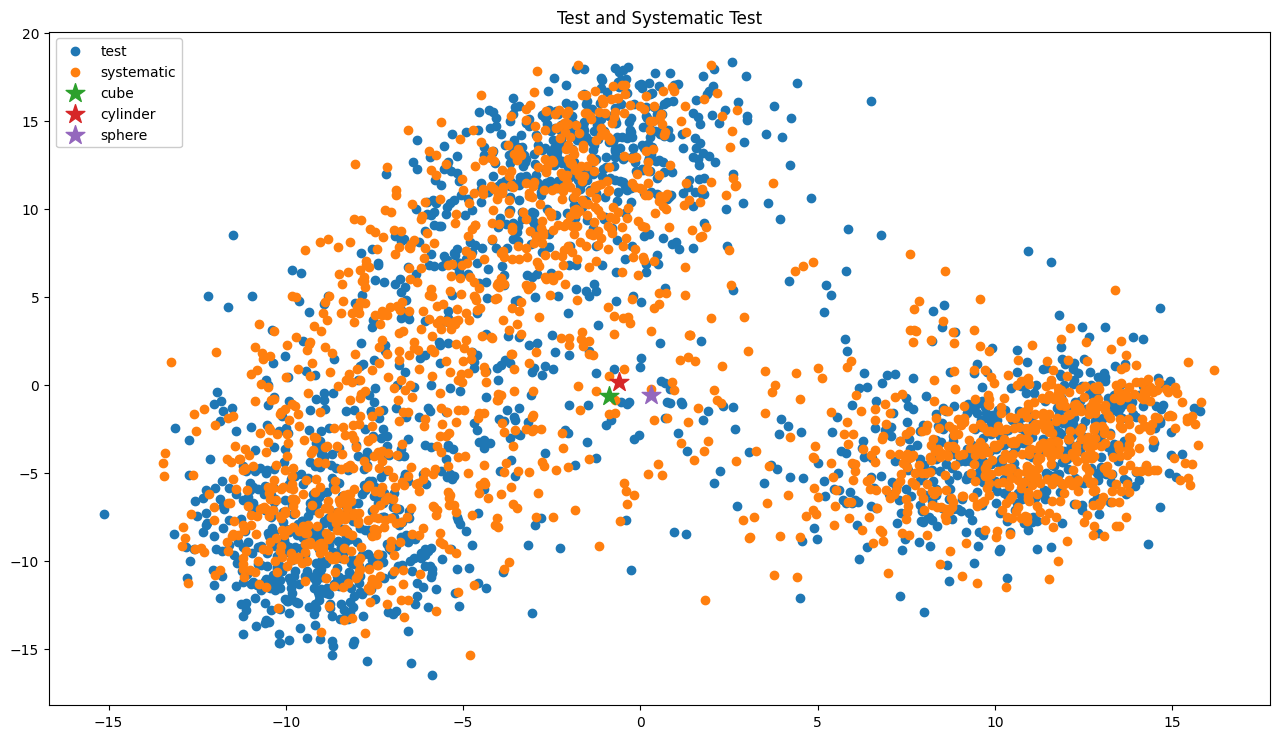

In [54]:
X = torch.cat([feats_by_set[set_]['shapes'] for set_ in ['test', 'systematic']]).numpy()
all_gts = [torch.full_like(gt_by_set[set_]['shapes'], tidx) for tidx, set_ in enumerate(['test', 'systematic'])]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, 
            all_gts,
            labels_to_use=['test', 'systematic'], 
            special_X=pca.transform(special_X),
            special_y=special_gts,
            special_labels_to_use=processor.inv_vocabulary, 
            don_t_label_these=[], 
            title='Test and Systematic Test')

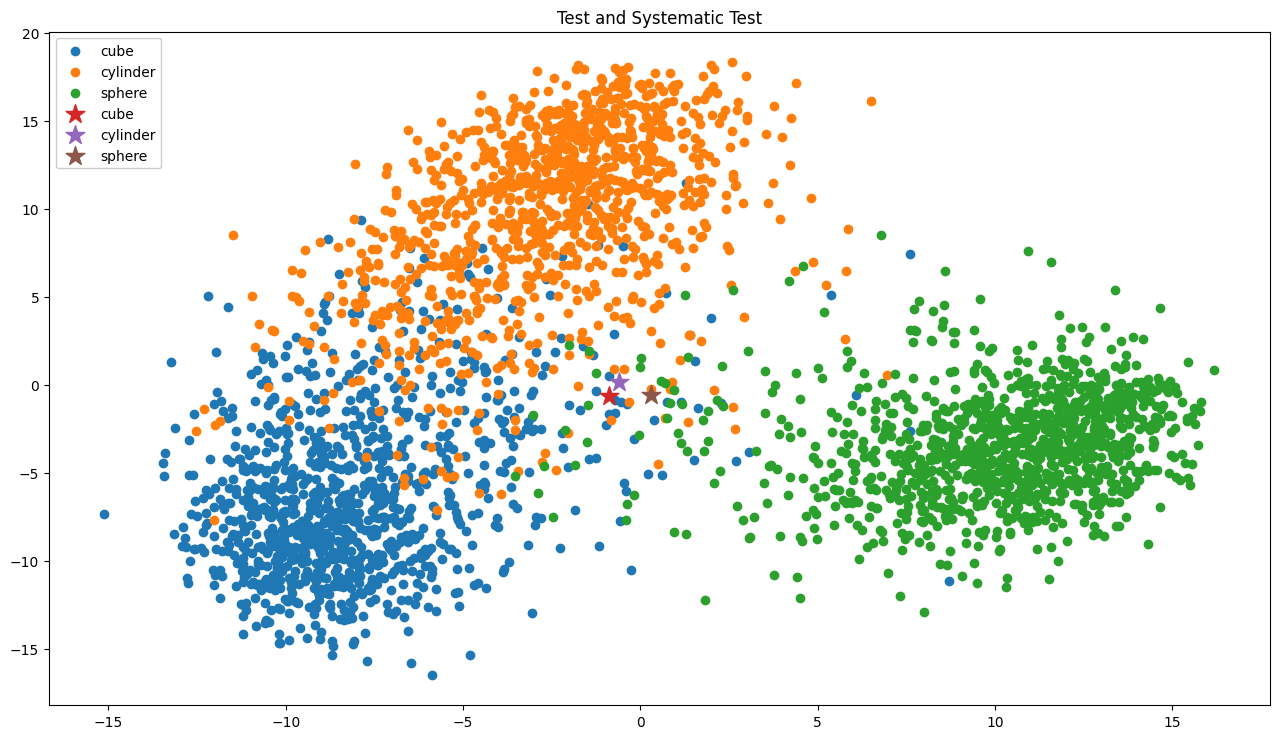

In [55]:
X = torch.cat([feats_by_set[set_]['shapes'] for set_ in ['test', 'systematic']]).numpy()
all_gts = [gt_by_set[set_]['shapes'] for set_ in ['test', 'systematic']]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, 
            all_gts,
#             labels_to_use=['test', 'systematic'], 
            special_X=pca.transform(special_X),
            special_y=special_gts,
            special_labels_to_use=processor.inv_vocabulary, 
            don_t_label_these=[], 
            title='Test and Systematic Test')

In [56]:
all_gts.shape, colors.shape, sizes.shape, materials.shape, shapes.shape

((3289,),
 torch.Size([1643]),
 torch.Size([1643]),
 torch.Size([1643]),
 torch.Size([1643]))

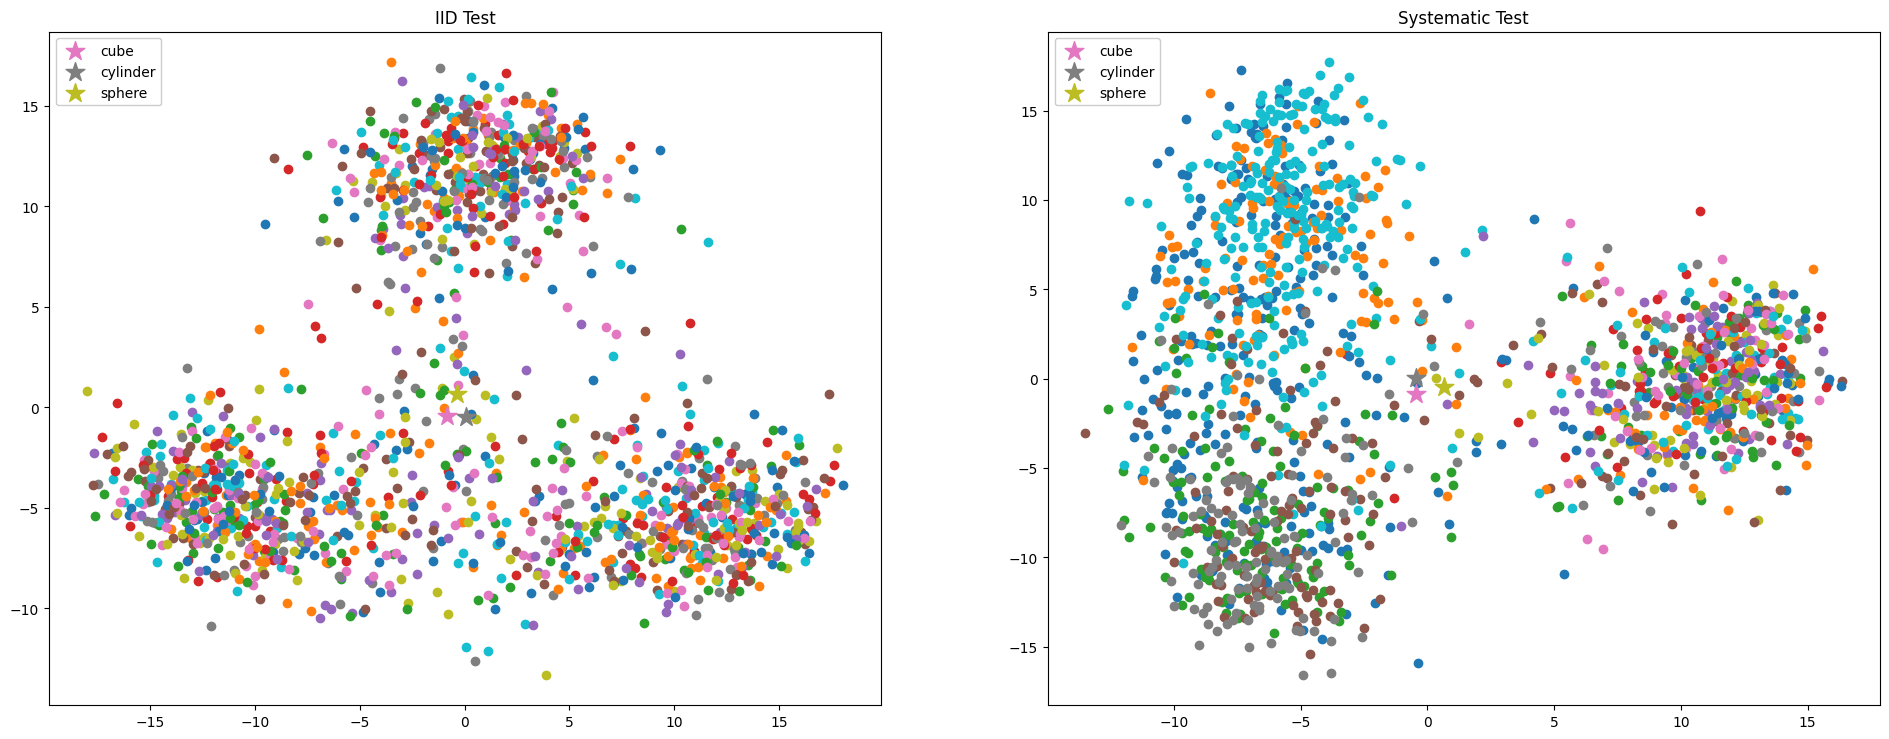

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

X = feats_by_set['test']['shapes'].numpy()
# all_gts = gt_by_set['test']['shapes'].numpy()
sizes, colors, materials, shapes = props_by_set['test']['shapes']
all_gts = colors.numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)


scatter_pca(
    X_2d, 
    all_gts, 
    special_X=pca.transform(special_X),
    special_y=special_gts,
    don_t_label_these=don_t_label_these, 
    title='IID Test', 
    ax=axs[0])


X = feats_by_set['systematic']['shapes'].numpy()
# all_gts = gt_by_set['systematic']['shapes'].numpy()
sizes, colors, materials, shapes = props_by_set['systematic']['shapes']
all_gts = colors.numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(
    X_2d, 
    all_gts, 
    special_X=pca.transform(special_X),
    special_y=special_gts,
    don_t_label_these=don_t_label_these,
    title='Systematic Test',
    ax=axs[1])

# plt.savefig(
#     'exports/acc-color-smaller-models.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [58]:
# %matplotlib notebook

In [59]:
# X = torch.cat([feats_by_set[set_]['shapes'] for set_ in ['test', 'systematic']]).numpy()
# all_gts = [torch.full_like(gt_by_set[set_]['shapes'], tidx) for tidx, set_ in enumerate(['test', 'systematic'])]
# all_gts = torch.cat(all_gts).numpy()

# pca = PCA(n_components=3)
# X_3d = pca.fit_transform(X)

# scatter_pca(X_3d,
#             all_gts,
#             labels_to_use=['test', 'systematic'],
#             special_X=pca.transform(special_X),
#             special_y=special_gts,
#             special_labels_to_use=processor.inv_vocabulary,
#             don_t_label_these=[],
#             title='Test and Systematic Test')

### Material Task

In [60]:
%matplotlib inline

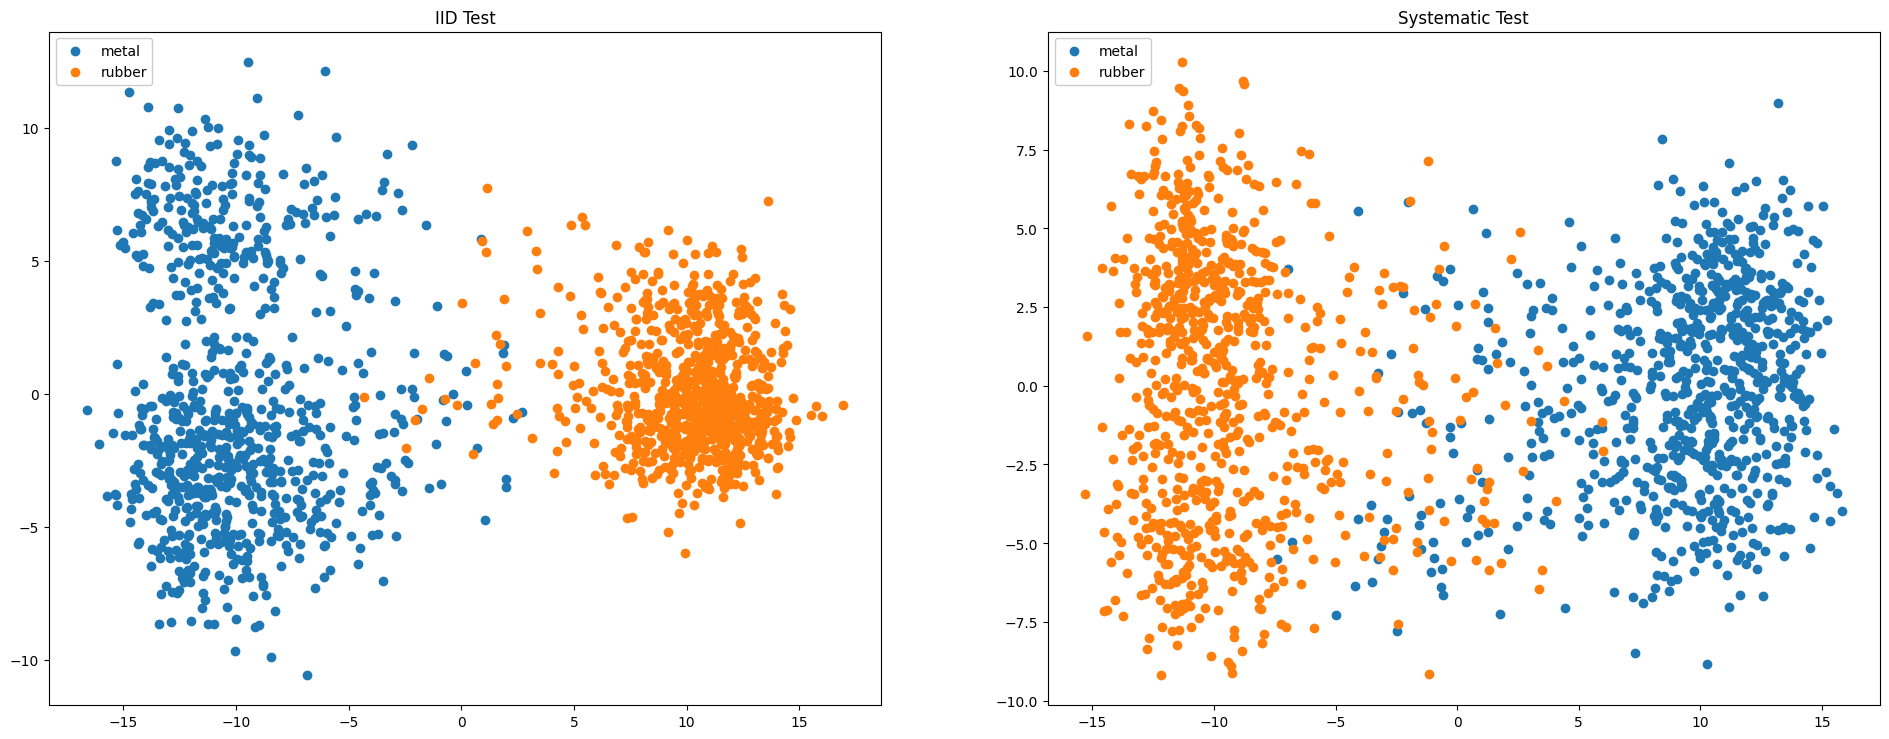

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

X = feats_by_set['test']['materials'].numpy()
all_gts = gt_by_set['test']['materials'].numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, don_t_label_these=[], title='IID Test', ax=axs[0])


X = feats_by_set['systematic']['materials'].numpy()
all_gts = gt_by_set['systematic']['materials'].numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, don_t_label_these=[], title='Systematic Test', ax=axs[1])

plt.show()

In [62]:
%matplotlib inline

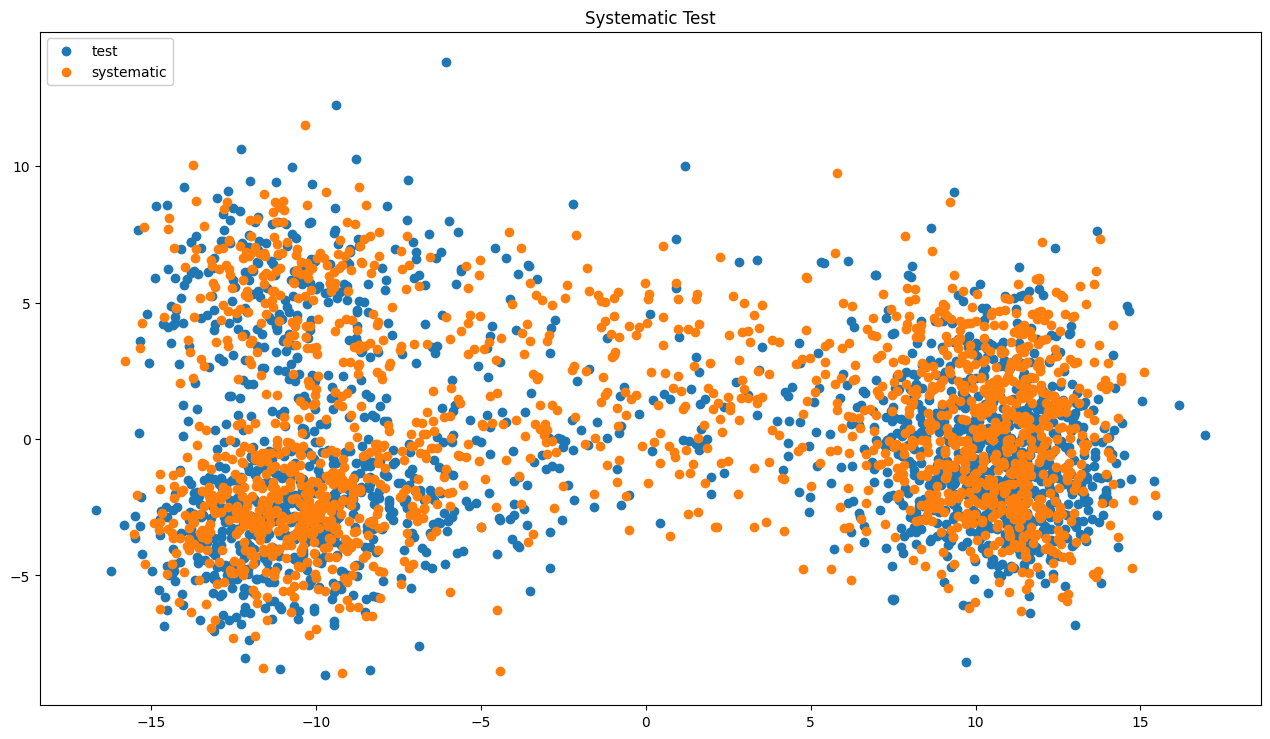

In [63]:
X = torch.cat([feats_by_set[set_]['materials'] for set_ in ['test', 'systematic']]).numpy()
all_gts = [torch.full_like(gt_by_set[set_]['materials'], tidx) for tidx, set_ in enumerate(['test', 'systematic'])]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, labels_to_use=['test', 'systematic'], don_t_label_these=[], title='Systematic Test')

### Size Task

In [64]:
%matplotlib inline

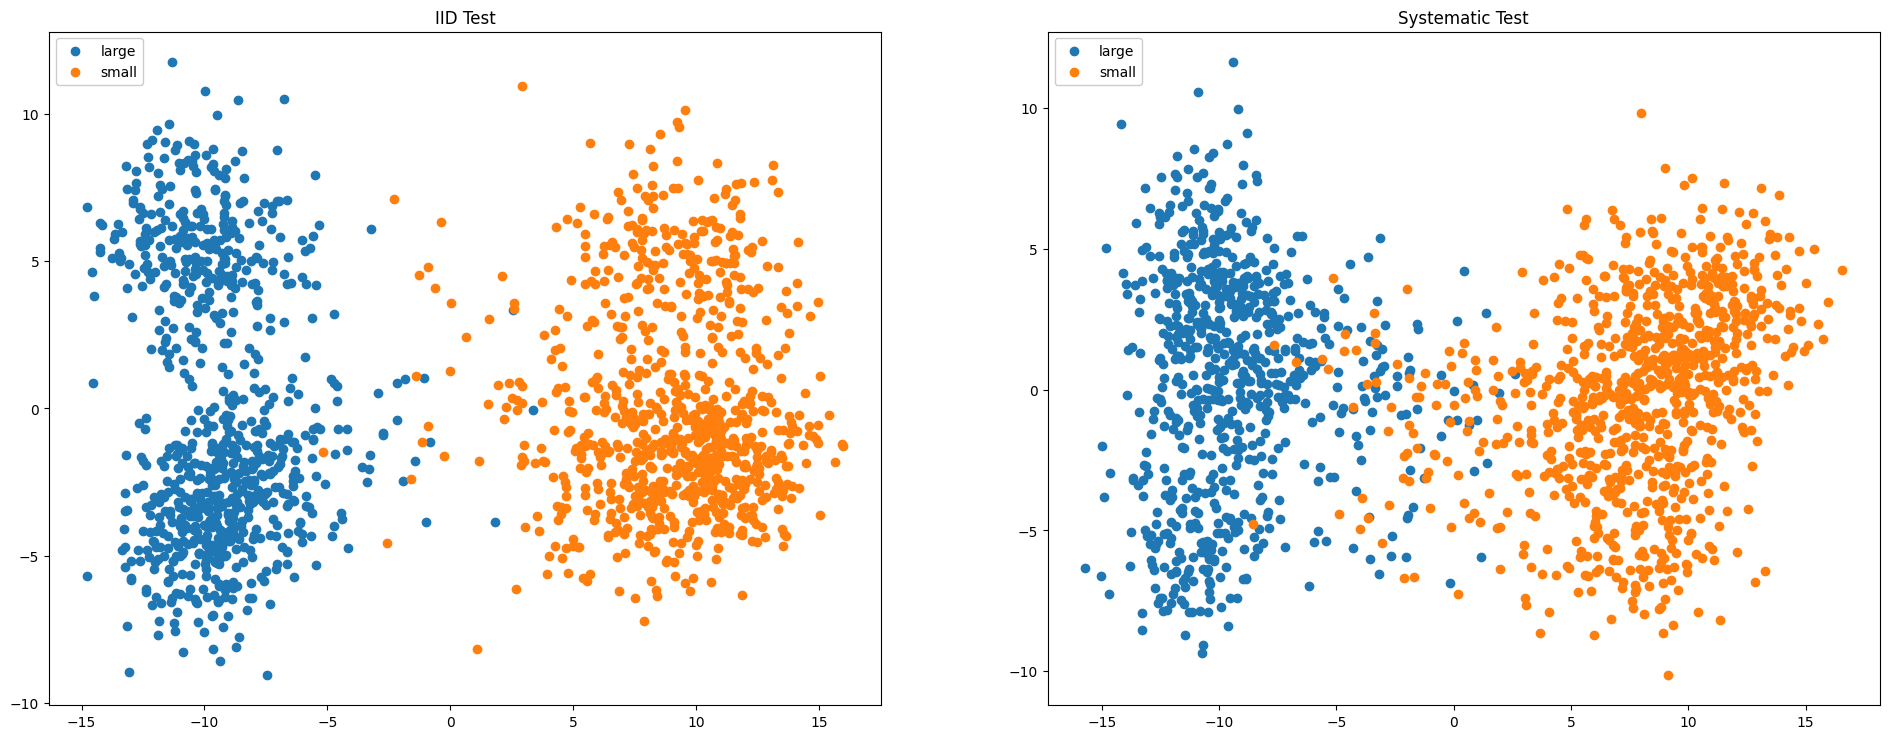

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

X = feats_by_set['test']['sizes'].numpy()
all_gts = gt_by_set['test']['sizes'].numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, don_t_label_these=[], title='IID Test', ax=axs[0])


X = feats_by_set['systematic']['sizes'].numpy()
all_gts = gt_by_set['systematic']['sizes'].numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, don_t_label_these=[], title='Systematic Test', ax=axs[1])

plt.show()

In [66]:
%matplotlib inline

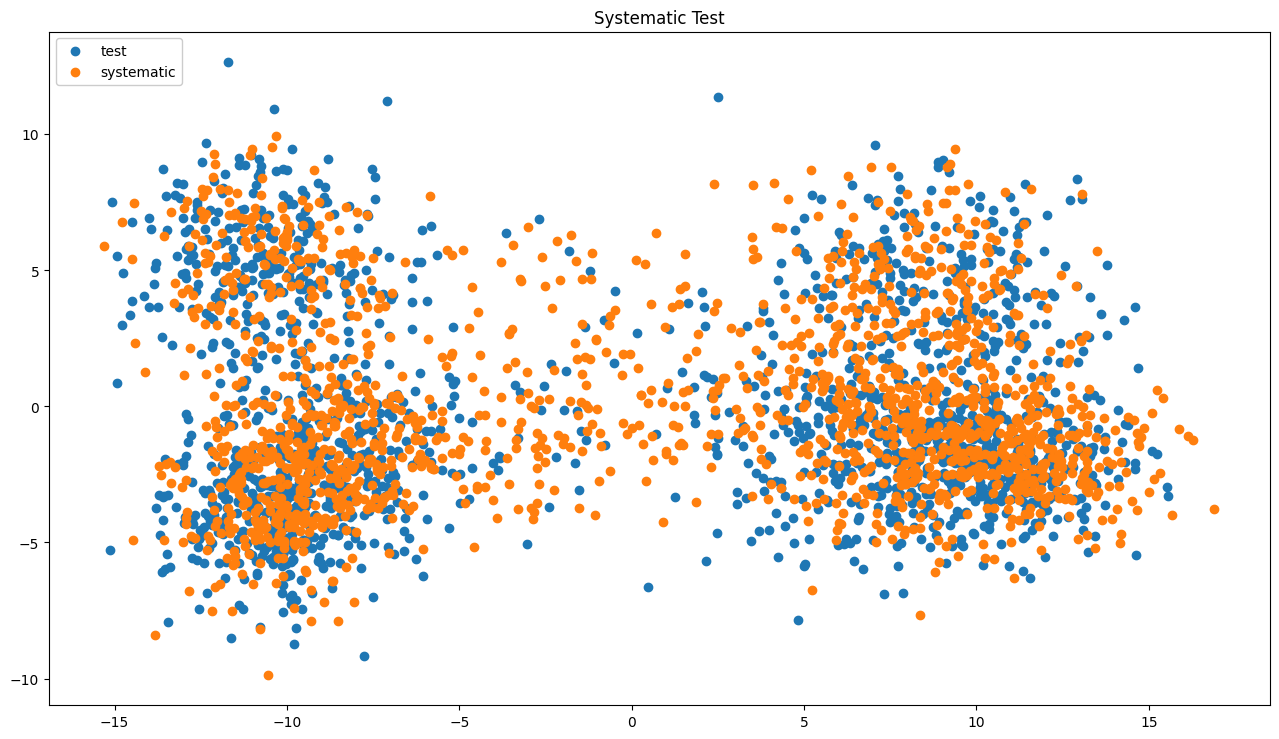

In [67]:
X = torch.cat([feats_by_set[set_]['sizes'] for set_ in ['test', 'systematic']]).numpy()
all_gts = [torch.full_like(gt_by_set[set_]['sizes'], tidx) for tidx, set_ in enumerate(['test', 'systematic'])]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, labels_to_use=['test', 'systematic'], don_t_label_these=[], title='Systematic Test')